## Step 5: Building a topographic volume $V(d,u,v)$ space using the $(u,v)$ parameterized $S_{ref}(x,y,z)$

Using $S(u,v)$, the $(u,v)$ parameterization of $S_{ref}(x,y,z)$ we can propagate the surface along the steepest gradient of its signed distance transform in desired stepsizes to map the surrounding 'normal' space external and internal to the cell. This produces a 'topographic' volume representation that is particularly useful for analysing surface features.

This workbook shows how to build the topographic space to enable a topographic surface to be extracted as well as to map the original Cartesian volume image into a topographic volume image.


### Load $S(x,y,z)$ and $S(u,v)$ parameterization and create an analysis save folder

We assume the user has worked through step 4 which generates and saves the (u,v) parameterization of the reference surface $S_{ref}(x,y,z)$ for an input cell surface mesh to the folder `example_results/bleb_example/step4_uv_mapping`. We also need the original image in the folder `example_data/img`. 

In [52]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import skimage.io as skio 
import scipy.io as spio

# example cell used
imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step5_topographic_space')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.

"""
Loading
"""
# original image
img_file = 'example_data/img/%s.tif' %(basefname)
img = skio.imread(img_file)

# load the pre-computed uv-mapping of S_ref(x,y,z)
uv_folder = 'example_results/%s/step4_uv_mapping' %(basefname)
uv_file = os.path.join(uv_folder, 
                       'uv_mapping_params.mat')
uv_map_obj = spio.loadmat(uv_file) # reads the .mat like a python dictionary. 

S_uv = uv_map_obj['uv_map'].copy()

### Propagating $S(u,v)$ to build the topographic volume space $V(d,u,v)$

The topographic volume space is build by propagating $S_{ref}(x,y,z)$ in cartesian space a total number of $D_{out}$ steps outwards and a total number of $D_{in}$ steps into the cell along the gradient of the signed distance transform, whilst being indexed by $(u,v)$ coordinates. 

The signed distance transform is computed after voxelizing $S(u,v)$ in Cartesian space.  

In [53]:
"""
Specify the alpha step-size - this is the regular step size in voxels to offset the surface every iteration.   

There are two ways to determine alpha:
    1. manual specification
    2. based on the mean (u,v) pixel size. 

We will use option 2 here which here gives approx 0.5 voxel. 
"""

# Option 1: manual specification 
alpha = 1 # step with one voxel

# Option 2: compute the 
delta_xx = np.diff(S_uv, axis=1) # column-wise difference in (x,y,z)
delta_yy = np.diff(S_uv, axis=0) # row-wise difference in (x,y,z)
# convert the difference to magnitude. 
delta_xx_abs = np.linalg.norm(delta_xx, axis=-1)
delta_yy_abs = np.linalg.norm(delta_yy, axis=-1)
# take the mean of the x-, y- direction magnitude 
alpha = .5*(np.mean(delta_xx_abs) + np.mean(delta_yy_abs)) 

print('======')
print('using alpha step-size: ', alpha)
print('======')

using alpha step-size:  0.472031831741333


We will now do the outer propagation with this the computed alpha step.  

In [54]:
import unwrap3D.Unzipping.unzip as uzip # this module handles the image-type mesh functions i.e. not triangle mesh representations.

# prop outwards. 
Suv_prop_outside = uzip.prop_ref_surface(S_uv[...,::-1], # since the uv parameterization uses the mesh vertices, which are opposite in convention to the image volume we need to flip the axis.
                                          vol_size=binary_img.shape,  # this is required to ensure volume coordinates.
                                          vol_binary = None, # we can specify a predefined binary for signed distance transform computation 
                                          d_step=alpha, # positive alpha = outwards 
                                          n_dist=None, # we don't specify because we will automatically infer from the surface mesh.
                                          surf_pts_ref=surf_mesh.vertices[...,::-1],
                                          pad_dist=15, # This gives extra padding just to make sure we absolutely cover protrusions
                                          smooth_method='uniform', # Propagating large distance needs to some instability, we apply 1D uniform filters to suppress this
                                          smooth_win=5) # sets the window size of the filter. 
print(Suv_prop_outside.shape) 
N_out = len(Suv_prop_outside) - 1 # this is the total number of steps.


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:27<00:00,  4.74it/s]

(129, 256, 512, 3)


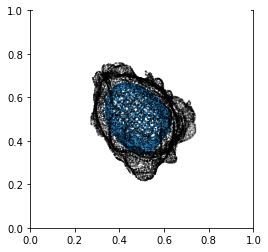

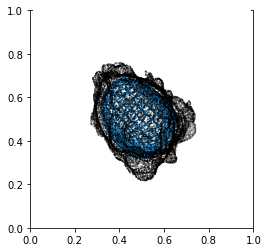

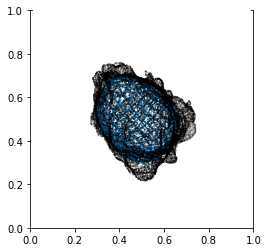

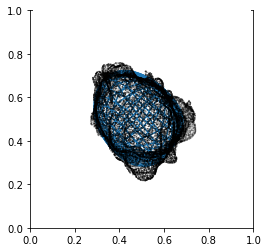

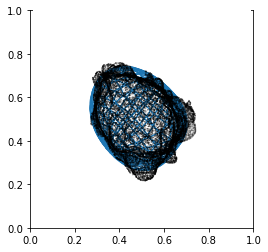

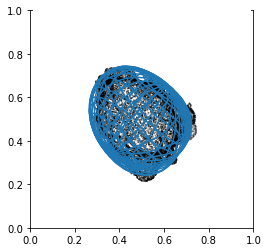

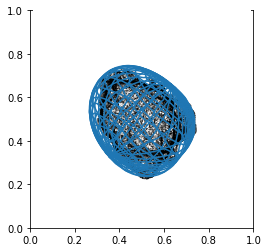

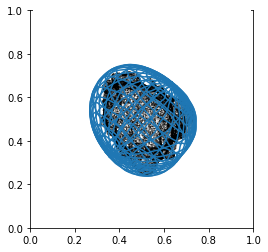

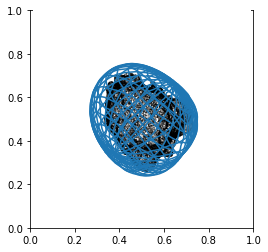

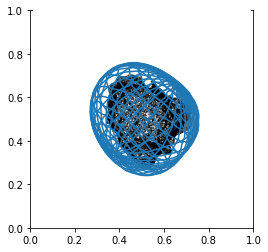

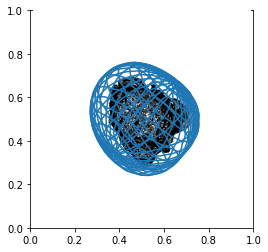

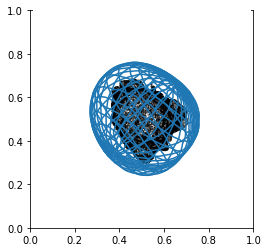

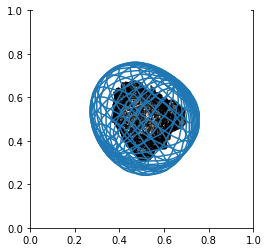

In [55]:
# use matplotlib and plot every 10th iteration wireframe surface to see the effect relative to the surface mesh.  
import pylab as plt 

sampling = 10

for ii in np.arange(0, len(Suv_prop_outside), sampling):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
    ax.set_box_aspect(aspect = (1,1,1)) # this works. 
    ax.scatter(surf_mesh.vertices[::sampling,0],
               surf_mesh.vertices[::sampling,1],
               surf_mesh.vertices[::sampling,2], color='k', s=0.1) # note the surface mesh vertices are inverse order to the image. 
    # plot the propagated surface.
    ax.plot_wireframe(Suv_prop_outside[ii][...,2], 
                      Suv_prop_outside[ii][...,1],
                      Suv_prop_outside[ii][...,0], rstride=16, cstride=16)
    ax.axis('off')
    ax.grid('off')
    plt.show()

We now do the inner propagation with the computed alpha step. The number of steps is harder to determine automatically for arbitrary shapes. We leave it for future work. At the moment it is easiest to manually set the total number of steps.

In [56]:
max_distance_inside = 30 # voxels. 

# further inside propagation. 
Suv_prop_inside = uzip.prop_ref_surface(S_uv[...,::-1], 
                                          vol_size=binary_img.shape,  
                                          vol_binary = None, # we can specify a predefined binary for signed distance transform. 
                                          d_step= -alpha,  # note sign reversal of step to move into the cell. 
                                          n_dist=max_distance_inside*1./alpha, 
                                          surf_pts_ref=surf_mesh.vertices[...,::-1], # not currently used to autodetermine number of steps
                                          pad_dist=15, 
                                          smooth_method='uniform', 
                                          smooth_win=5)

print(Suv_prop_inside.shape) 
N_in = len(Suv_prop_inside) - 1 # this is the total number of steps into cell. 

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:12<00:00,  5.33it/s]

(65, 256, 512, 3)


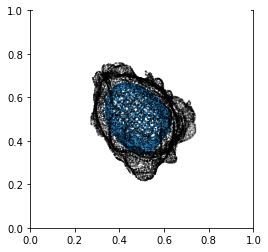

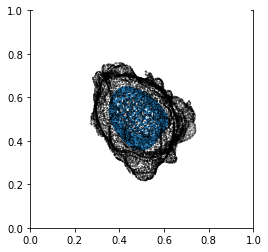

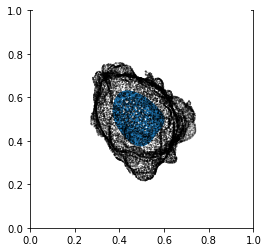

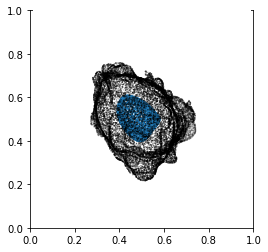

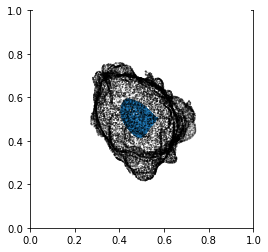

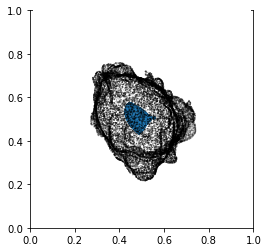

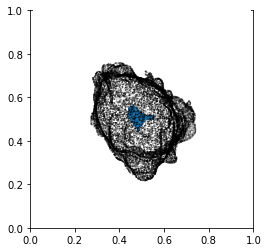

In [57]:
# use matplotlib and plot every 10th iteration wireframe surface to see the effect relative to the surface mesh with this inside surface propagation  
import pylab as plt 

sampling = 10

for ii in np.arange(0, len(Suv_prop_inside), sampling):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
    ax.set_box_aspect(aspect = (1,1,1)) # this works. 
    ax.scatter(surf_mesh.vertices[::sampling,0],
               surf_mesh.vertices[::sampling,1],
               surf_mesh.vertices[::sampling,2], color='k', s=0.1) # note the surface mesh vertices are inverse order to the image. 
    # plot the propagated surface.
    ax.plot_wireframe(Suv_prop_inside[ii][...,2], 
                      Suv_prop_inside[ii][...,1],
                      Suv_prop_inside[ii][...,0], rstride=16, cstride=16)
    ax.axis('off')
    ax.grid('off')
    plt.show()

Finally, we combine both the outside and inside propagation accounting for double counting of the reference surface. 

In [58]:
topographic_coordinates = np.concatenate([Suv_prop_inside[::-1], # flip the inside propagation so that we have continuous evolution from innermost to outermost.
                                          Suv_prop_outside[1:]], axis=0)

print('final topographic coordinates shape: ', topographic_coordinates.shape)


final topographic coordinates shape:  (193, 256, 512, 3)


### Mapping Cartesian volume quantities $I(V(x,y,z))$ into the topographic volume space $V(d,u,v)$

We have now constructed a bijective mapping from topographic $(d,u,v)$ into Cartesian $(x,y,z)$ space. Specifically it maps a subvolume around $S_{ref}(x,y,z)$. We can now visualize any scalar quantity of interest in our topographic space with the huge huge advantage of seeing everything in the vicinity of the cell surface in a single field-of-view !   

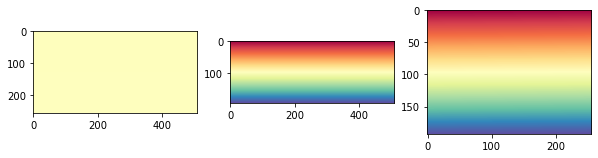

In [59]:
"""
For fun, let's take a look at how the topographic volume maps into the Cartesian volume. 

We will do this by coloring each (d,u,v) coordinate with a unique color. 
"""
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

topographic_space_index = np.arange(np.prod(topographic_coordinates.shape[:3])).reshape(topographic_coordinates.shape[:3])
topographic_space_color = np.uint8(255*vol_colors.get_colors(topographic_space_index,
                                                             colormap=cm.Spectral)[...,:3])


# check the mid-slices of the colormap to see how it looks in the three orthogonal views.
topography_size = topographic_coordinates.shape[:3]

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(topographic_space_color[topography_size[0]//2,:,:])
plt.subplot(132)
plt.imshow(topographic_space_color[:,topography_size[1]//2,:])
plt.subplot(133)
plt.imshow(topographic_space_color[:,:,topography_size[2]//2])
plt.show()

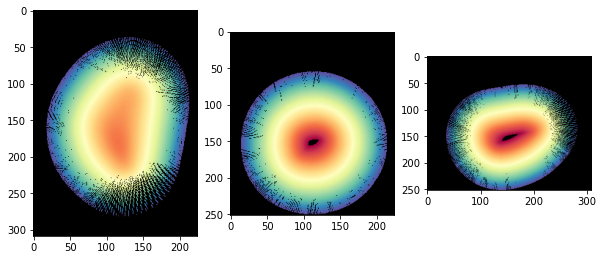

In [60]:
# Now we initialise an array based on the size of the original cartesian volume image
topographic_cartesian_color = np.zeros(binary_img.shape+(3,), dtype=np.uint8)

#populate the color using the topographic coordinates. for simplicity we cast the float to int.
topographic_cartesian_color[topographic_coordinates[...,0].ravel().astype(np.int32), 
                            topographic_coordinates[...,1].ravel().astype(np.int32), 
                            topographic_coordinates[...,2].ravel().astype(np.int32)] = topographic_space_color.reshape(-1,3)

img_size = binary_img.shape[:3]


# Now we take a look at the topography space mapped into the volume ! 
# We see the covering is good except as expected the North/South poles where we expect undersampling. 
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(topographic_cartesian_color[img_size[0]//2,:,:])
plt.subplot(132)
plt.imshow(topographic_cartesian_color[:,img_size[1]//2,:])
plt.subplot(133)
plt.imshow(topographic_cartesian_color[:,:,img_size[2]//2])
plt.show()



Now let's map the original image into a topographic volume image !. We do this by linear interpolation.

In [61]:
import unwrap3D.Image_Functions.image as image_fn

topographic_I = np.uint16(image_fn.map_intensity_interp3(topographic_coordinates.reshape(-1,3), 
                                                       grid_shape=img.shape, 
                                                       I_ref=img))
topographic_I = topographic_I.reshape(topographic_coordinates.shape[:-1])

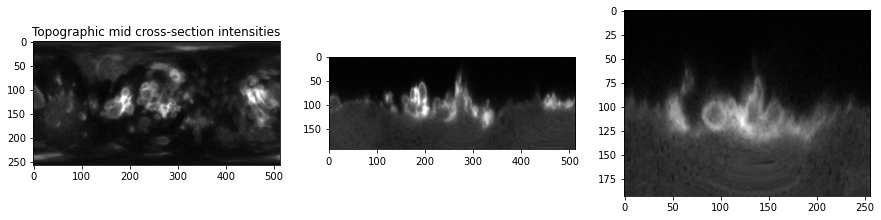

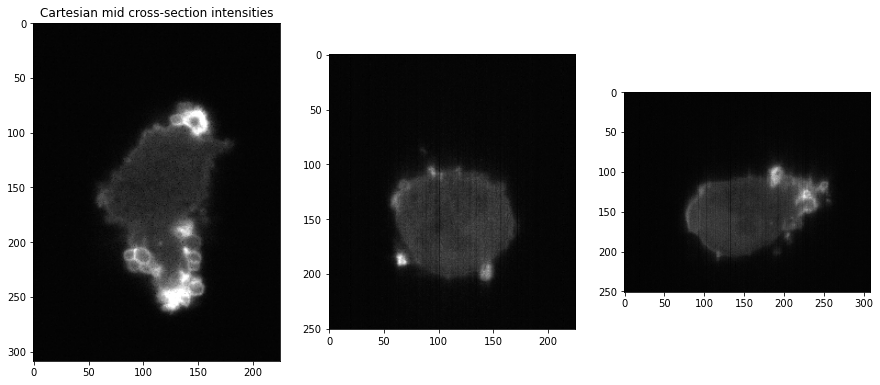

In [62]:
# visualize the mid cross sections of topographic and original cartesian.
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Topographic mid cross-section intensities')
plt.imshow(np.rot90(topographic_I[topography_size[0]//2,:,:],2), cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(topographic_I[:,topography_size[1]//2,:],2), cmap='gray')
plt.subplot(133)
plt.imshow(np.rot90(topographic_I[:,:,topography_size[2]//2],2), cmap='gray')
plt.show()


plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Cartesian mid cross-section intensities')
plt.imshow(img[img_size[0]//2,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(img[:,img_size[1]//2,:], cmap='gray')
plt.subplot(133)
plt.imshow(img[:,:,img_size[2]//2], cmap='gray')
plt.show()

You will notice that the tips of the protrusions appear 'squeezed together'. This is because the equiareal parameterization was of $S_{ref}(x,y,z)$. If this was of $S(x,y,z)$ then the protrusions would be represented much more accurately. One way to do this is to use the interpolated coordinates of $S(x,y,z)$ in the area-distoration relaxation instead.

In [63]:
# Finally we save the constructed topographic coordinates - we will use this next to map the original segmentation binary and derive a topographic surface mesh

"""
Save the basic parameters for replication. 
"""
spio.savemat(os.path.join(savefolder, 
                          'topographic_volume_space.mat'), 
             {'topographic_map': topographic_coordinates.astype(np.float32), 
              'uv_map_file': uv_file, 
              'N_inside': N_in, 
              'N_outside': N_out}) 

## We now proceed to step 6 notebook to obtain the topographic surface parameterization of the input surface